In [1]:
from IPython.display import Image

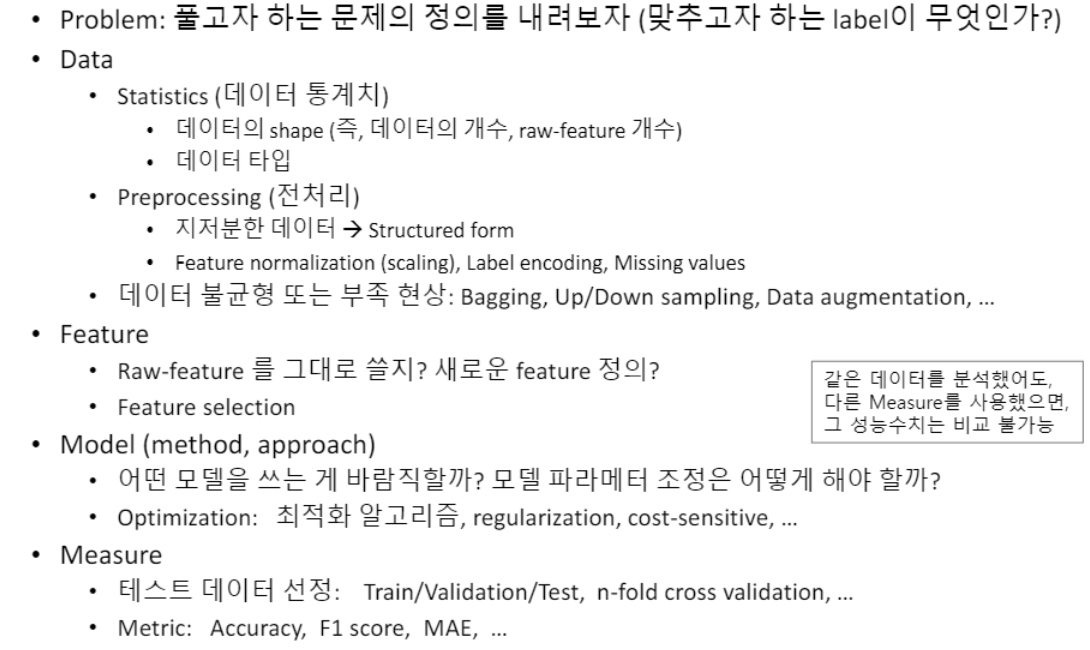

In [2]:
Image("C:/Users/joyh1/Desktop/DSC/modeling_process.png")

# 문제정의

- 해당 데이터는 Bible의 라틴 버전이라고 할 수 있는 'Avila Bible'이라는 Bible의 800개의 이미지로부터 추출된 데이터
- 이러한 데이터들을 이용해서 Avila Bible 이미지의 패턴을 분류하는 문제(Classification)
- Labels : A,B,C,D,E,F,G,H,I,W,X,Y (패턴의 종류들)

- Attribute(Feature) 의미 파악
- F1 : 열간 거리
- F2 : 상단 여백
- F3 : 하단 여백
- F4 : exploitation
- F5 : 줄 개수
- F6 : 모듈 비율
- F7 : 선형 간격
- F8 : 두께
- F9 : 피크(?) 수
- F10 : 모듈비율을 선형간격으로 나눈 값

# 데이터 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
# 데이터 로드(원본파일이 txt파일로 되어있었는데 구분자가 쉼표(,)여서 확장자명 csv파일로 바꾸어주고 로드)

#### py파일로 바꿔줄때 데이터 들어있는 fold_dir 수정해주기!!!!
fold_dir = '../data/'

train = pd.read_csv(fold_dir+"avila-tr.txt", sep =',', header=None)
test = pd.read_csv(fold_dir+"avila-ts.txt", sep=',', header=None)

print(f'Train 데이터 Shape : {train.shape}')
print(f'Test 데이터 Shape : {test.shape}')

Train 데이터 Shape : (10430, 11)
Test 데이터 Shape : (10437, 11)


In [3]:
train.head()

0         1         2         3         4         5         6   \
0  0.266074 -0.165620  0.320980  0.483299  0.172340  0.273364  0.371178   
1  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
2 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
3  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
4  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   

         7         8         9  10  
0  0.929823  0.251173  0.159345  A  
1  0.636203  0.282354  0.515587  A  
2 -0.888236 -0.123005  0.582939  A  
3  1.051693  0.594169 -0.533994  A  
4  0.051062  0.032902 -0.086652  F

In [4]:
# Train, Test 데이터 결합시키기
data = pd.concat([train, test], axis=0)

# Attribute이름 조건, 반복문으로 변경
for i in range(0, len(data.columns)):
    if i == 10:
        data = data.rename(columns={i:'label'})
    else:
        data = data.rename(columns={i:f'F{i+1}'})
data = data.reset_index(drop=True)
data.tail()

F1        F2        F3        F4        F5        F6        F7  \
20862 -0.128929 -0.040001  0.057807  0.557894  0.261718 -0.930856 -0.044076   
20863  0.266074  0.556689 -0.020434  0.176624  0.261718 -0.515608  0.597681   
20864 -0.054866  0.580242  0.032912 -0.016668  0.261718  1.519109  0.371178   
20865  0.080916  0.588093  0.015130  0.002250  0.261718 -0.930856 -0.270579   
20866  0.377169  0.014957  0.381439  0.292753  0.261718 -1.470679 -0.006326   

             F8        F9       F10 label  
20862  1.158458  2.277968 -0.699884     X  
20863  0.178349  0.625350 -0.657245     G  
20864 -0.985508 -0.403638  1.276301     A  
20865  0.163807 -0.091823 -0.593329     F  
20866 -0.494919 -0.247731 -1.212974     H

In [5]:
# 결측치 확인
data.isnull().sum()

F1       0
F2       0
F3       0
F4       0
F5       0
F6       0
F7       0
F8       0
F9       0
F10      0
label    0
dtype: int64

In [6]:
# 데이터 행,열 갯수 확인
data.shape

(20867, 11)

In [7]:
# 데이터 타입확인
data.dtypes

F1       float64
F2       float64
F3       float64
F4       float64
F5       float64
F6       float64
F7       float64
F8       float64
F9       float64
F10      float64
label     object
dtype: object

In [8]:
# object타입인 label의 기술통계량 확인
data.describe(include=object)

label
count   20867
unique     12
top         A
freq     8572

In [9]:
# label개수를 살펴보고 Class imbalance가 있는지 살펴보기
data['label'].value_counts()

A    8572
F    3923
E    2190
I    1663
X    1044
H    1039
G     893
D     705
Y     533
C     206
W      89
B      10
Name: label, dtype: int64

In [10]:
# Feature Normalization이 필요한지 아닌지 보기 위해 수치로 이루어진 Feature기술통계량 보기
data.describe()
# F2, F3, F7의 값들의 최대값이 매우 큰걸 보아하니 이상치가 존재하고 feature scaler가 필요할 듯 보인다.

F1            F2            F3            F4            F5  \
count  2.086700e+04  20867.000000  20867.000000  20867.000000  2.086700e+04   
mean  -3.306656e-09      0.018498      0.002329      0.000115  5.697992e-08   
std    1.000007e+00      2.853117      1.058203      0.999997  9.999948e-01   
min   -3.498799e+00     -2.426761     -3.210528     -5.440122 -4.922215e+00   
25%   -1.289290e-01     -0.259834      0.064919     -0.527256  1.723400e-01   
50%    5.622900e-02     -0.055704      0.217845      0.089437  2.617180e-01   
75%    2.043550e-01      0.203385      0.352988      0.643738  2.617180e-01   
max    1.181992e+01    386.000000     50.000000      3.987152  1.066121e+00   

                 F6            F7            F8            F9           F10  
count  20867.000000  20867.000000  20867.000000  20867.000000  20867.000000  
mean       0.002540      0.003977      0.000028      0.002108      0.000069  
std        1.065179      1.153325      1.000003      1.045362      1.000010  
min       -7.450257    -11.935457     -4.247781     -5.486218     -6.719324  
25%       -0.598658     -0.044076     -0.543914     -0.372457     -0.515235  
50%       -0.058835      0.220177      0.108279      0.064084     -0.025918  
75%        0.564038      0.446679      0.648813      0.500624      0.528425  
max       53.000000     83.000000     13.173081     44.000000     11.911338

In [11]:
# LabelEncoding하기
label_encoder = preprocessing.LabelEncoder()
# Encoding할 값 할당해서 fit, transform해줘서 기존 label값에서 바꿔주기
# 바꿔서 반환되는 값의 type은 int형이다.
data['label'] = label_encoder.fit_transform(data['label'])
data.head()

F1        F2        F3        F4        F5        F6        F7  \
0  0.266074 -0.165620  0.320980  0.483299  0.172340  0.273364  0.371178   
1  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
2 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
3  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
4  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   

         F8        F9       F10  label  
0  0.929823  0.251173  0.159345      0  
1  0.636203  0.282354  0.515587      0  
2 -0.888236 -0.123005  0.582939      0  
3  1.051693  0.594169 -0.533994      0  
4  0.051062  0.032902 -0.086652      5

## label imbalance 고민

In [12]:
# 데이터 label불균형을 해소해야함 -> label이 적은 게 여러개..(B,W,C...) -> 데이터 개수를 조절하는 up/down sampling보다는
# Loss weight control을 사용해야할 듯함.. -> 비율이 적은 데이터에 큰 W값을 부여하는 'Cost-sensitive learning' 채택해보자.
#class_weight를 계산해주는 메소드

from sklearn.utils.class_weight import compute_class_weight
label = [0]*8572 + [1]*10 + [2]*206 + [3]*705 + [4]*2190 + [5]*3923 + [6]*893 + [7]*1039 + [8]*1663 + [9]*89 + [10]*1044 + [11]*533
compute_class_weight(class_weight='balanced',
                     classes=np.unique(label),
                    y= label)

array([  0.20286009, 173.89166667,   8.44134304,   2.46654846,
         0.79402588,   0.44326196,   1.9472751 ,   1.67364453,
         1.04565043,  19.53838951,   1.66562899,   3.26250782])

In [13]:
# 모델에 인자로 추가해줄 class별 weight값 dict형태로 할당
class_weight = {0:0.2, 1:173, 2:8.4, 3:2.4, 4:0.7, 5:0.4, 6:1.9,
                7:1.6, 8:1, 9:19, 10:1.6, 11:3.2}
# Random Forest적용해보기

In [14]:
# sklearn에 class_weight를 주는 메소드가 따로 없어서 weight를 부여하는 새로운 feature를 하나 만들기
class_weight

{0: 0.2,
 1: 173,
 2: 8.4,
 3: 2.4,
 4: 0.7,
 5: 0.4,
 6: 1.9,
 7: 1.6,
 8: 1,
 9: 19,
 10: 1.6,
 11: 3.2}

In [15]:
data['weight'] = ''
for key in class_weight.keys():
    data.loc[data['label'] == key, 'weight'] = class_weight[key]
data.head()

F1        F2        F3        F4        F5        F6        F7  \
0  0.266074 -0.165620  0.320980  0.483299  0.172340  0.273364  0.371178   
1  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
2 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
3  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
4  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   

         F8        F9       F10  label weight  
0  0.929823  0.251173  0.159345      0    0.2  
1  0.636203  0.282354  0.515587      0    0.2  
2 -0.888236 -0.123005  0.582939      0    0.2  
3  1.051693  0.594169 -0.533994      0    0.2  
4  0.051062  0.032902 -0.086652      5    0.4

In [16]:
# weight값 잘 들어갔는지 확인
data['weight'].value_counts()

0.2      8572
0.4      3923
0.7      2190
1.6      2083
1.0      1663
1.9       893
2.4       705
3.2       533
8.4       206
19.0       89
173.0      10
Name: weight, dtype: int64

In [17]:
# 데이터프레임 칼럼명 재배열
col_order = [f"F{x}" for x in range(1, 11)] + ['weight','label']
final_data = data[col_order]
final_data.head()

F1        F2        F3        F4        F5        F6        F7  \
0  0.266074 -0.165620  0.320980  0.483299  0.172340  0.273364  0.371178   
1  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
2 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
3  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
4  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   

         F8        F9       F10 weight  label  
0  0.929823  0.251173  0.159345    0.2      0  
1  0.636203  0.282354  0.515587    0.2      0  
2 -0.888236 -0.123005  0.582939    0.2      0  
3  1.051693  0.594169 -0.533994    0.2      0  
4  0.051062  0.032902 -0.086652    0.4      5

# Feature

# Feature Scaler 정하기 위해 데이터 분포양상 살펴보기

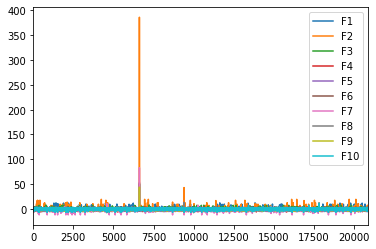

In [18]:
# F1~F10 feature들 분포 살펴보기 -> 이상치가 존재한다 -> 
data[[f"F{x}" for x in range(1,11)]].plot()

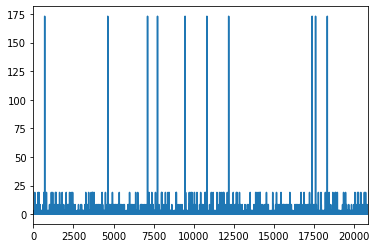

In [19]:
# weight값 분포살펴보기 -> 이상치가 많다
data['weight'].plot()

In [20]:
# Feature들의 분포를 종합해본 결과 이상치에 민감하지 않은 Robustsclaer가 적절할 것 같다.

# Model
- 선택할 모델 리스트 : Linear regression, Logistic regression, Support Vector Machine(SVM or SVC), Support Vector Regression, Random Forest, Gaussian naive bayes, Multilayer perceptron, Decision Tree 

In [21]:
# 어떤 모델은 선정!? => 분류.. Logistic Regression, SVM, RF, MLP  써서 성능 좋은 걸로 선택!

## ANN(MLP Classifier) 

In [22]:
features = []
for i in final_data.columns[:-1]:
    features.append(i)
print(features)

['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'weight']


## modeling_2

Fold 횟수 : 1
Train accuracy : 1.0
Test accuracy : 0.9992812649736463
Fold 횟수 : 2
Train accuracy : 0.9998202839513568
Test accuracy : 0.9988021082894106
Fold 횟수 : 3
Train accuracy : 0.999460884149994
Test accuracy : 0.9980829139707644
Fold 횟수 : 4
Train accuracy : 0.9999400982388882
Test accuracy : 0.9995207284926911
Fold 횟수 : 5
Train accuracy : 1.0
Test accuracy : 0.9997603642463455

전체 평균 Accuracy : 0.9990894759945717
Text(0.5, 0, 'iter_number')
Text(0, 0.5, 'loss_value')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1715
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       434
           5       1.00      1.00      1.00       768
           6       1.00      1.00      1.00       201
           7       1.00      0.99      1.00       193
           8       1.00      1.00    

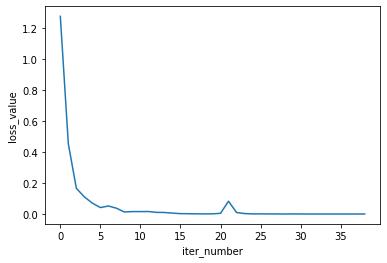

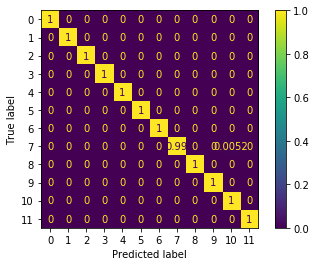

In [28]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
scaler = preprocessing.RobustScaler()
kf = KFold(n_splits=5, shuffle=True)

accrs = []
fold_idx = 1

for train_idx, test_idx in kf.split(final_data):
    print(f'Fold 횟수 : {fold_idx}')
    train_d, test_d = final_data.iloc[train_idx], final_data.iloc[test_idx]
    
    
    train_y = train_d['label']
    train_x = train_d[features]
    train_x = scaler.fit_transform(train_x)
    
    test_y = test_d['label']
    test_x = test_d[features]
    test_x = scaler.transform(test_x)
    # L2 normalization(파라미터 커지는거 제한) 
    model = MLPClassifier(hidden_layer_sizes=[512, 256, 64, 16], max_iter=500, random_state=12)
    model.fit(train_x, train_y)
    
    pred_y = model.predict(test_x)
    
    train_accr = model.score(train_x, train_y)
    test_accr = model.score(test_x, test_y)
    print('Train accuracy :', train_accr)
    print('Test accuracy :', test_accr)
    accrs.append(test_accr)
    
    # loss value plot
    loss_curve = model.loss_curve_
    
    fold_idx += 1
print()
print("전체 평균 Accuracy :", np.average(accrs))
print(plt.xlabel('iter_number'))
print(plt.ylabel('loss_value'))
print(plt.plot(loss_curve))
plot_confusion_matrix(model, test_x, test_y, normalize='true')
print(classification_report(test_y, pred_y, labels= [x for x in range(0,12)]))


# optimization converge안되는 문제 어떻게 해결할까...? => hidden_layer 사이즈와 Max_iter횟수 동시에 키우기
# precision, recall 알아보기

## modeling_1

Fold 횟수 : 1
Train accuracy : 0.9478823458934883
Test accuracy : 0.9046478198370868
Fold 횟수 : 2
Train accuracy : 0.9653148026118732
Test accuracy : 0.9333972208912314
Fold 횟수 : 3
Train accuracy : 0.9819695699053552
Test accuracy : 0.949436855978912
Fold 횟수 : 4
Train accuracy : 0.9387804001437642
Test accuracy : 0.9039060627845674
Fold 횟수 : 5
Train accuracy : 0.9609440517551217
Test accuracy : 0.9213994728013419

전체 평균 Accuracy : 0.922557486458628


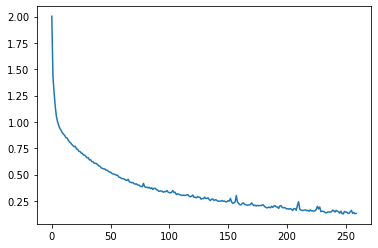

None


In [18]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
scaler = preprocessing.MaxAbsScaler()
kf = KFold(n_splits=5, shuffle=True)

accrs = []
fold_idx = 1

for train_idx, test_idx in kf.split(data):
    print(f'Fold 횟수 : {fold_idx}')
    train_d, test_d = data.iloc[train_idx], data.iloc[test_idx]
    
    pca = PCA(n_components=7)
    
    train_y = train_d['label']
    train_x = train_d[features]
    train_x = scaler.fit_transform(train_x)
    train_x = pca.fit_transform(train_x)
    
    test_y = test_d['label']
    test_x = test_d[features]
    test_x = scaler.transform(test_x)
    test_x = pca.transform(test_x)
                                    # L2 normalization(파라미터 커지는거 제한) # [512,128,16]
    model = MLPClassifier(hidden_layer_sizes=[512, 256, 128, 64, 16], max_iter=1000, alpha=0.0005, random_state=1)
    model.fit(train_x, train_y)
    
    train_accr = model.score(train_x, train_y)
    test_accr = model.score(test_x, test_y)
    print('Train accuracy :', train_accr)
    print('Test accuracy :', test_accr)
    accrs.append(test_accr)
    
    # loss value plot
    loss_curve = model.loss_curve_
    
    fold_idx += 1
print()
print("전체 평균 Accuracy :", np.average(accrs))
print(plt.plot(loss_curve))
print(plt.show())
# optimization converge안되는 문제 어떻게 해결할까...? => hidden_layer 사이즈와 Max_iter횟수 동시에 키우기

## Logistic Regression

In [113]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
# feature 담기
features = []
for i in final_data.columns[:-1]:
    features.append(i)
    
# feature scaler로 MinMaxSclaer 사용 => Scaler적용할 때 train에는 fit_transofrm하지만 test에는 transform만!
scaler = preprocessing.RobustScaler()

# Kfold 개수 할당해주기 , shuffle허용으로 랜덤샘플링 허용
kf = KFold(n_splits=5, shuffle=True)

# Kfold 모두 진행할 때마다 accuracy담을 리스트 할당
accrs = []

# fold 진행 횟수 출력
fold_idx = 1

# 최종 데이터셋에서 Train, Test 데이터 분할
for train_idx, test_idx in kf.split(data):
    print(f'Fold 횟수 : {fold_idx}')
    pca = PCA(n_components=5)
    
    train_d, test_d = data.iloc[train_idx], data.iloc[test_idx]
    
    # Train data의 Feature와 Label 할당
    train_y = train_d['label']
    train_x = train_d[features]
    train_x = scaler.fit_transform(train_x)
    train_x = pca.fit_transform(train_x)
    
    # Test data의 Feature와 Label 할당
    test_y = test_d['label']
    test_x = test_d[features]
    test_x = scaler.transform(test_x)
    test_x = pca.transform(test_x)
    # 모델 정의, 최적화 알고리즘 'ibfgs' 적용, max_iter를 추가안했을 때는 fail to converge(최적화 실패)라고 떴었음..
    model = LogisticRegression(solver='lbfgs', max_iter=2000)
    # Train data로 모델 학습
    model.fit(train_x, train_y)
    
    # Train 데이터로 accuracy 평가
    train_accr = model.score(train_x, train_y)
    # Test 데이터로 검증했을 때 accuracy 평가
    test_accr = model.score(test_x, test_y)
    
    print(train_accr)
    print(test_accr)
    
    # fold마다 accuracy를 list에 담기
    accrs.append(test_accr)
    
    # fold 횟수 1번할 때마다 1회 추가
    fold_idx += 1 
    
# Kfold 모두 시행후 평균 정확도 출력
print("전체 fold평균: ", np.average(accrs))



Fold 횟수 : 1
0.9607619960462469
0.9609487302347868
Fold 횟수 : 2


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9623195351344875
0.9599904168663153
Fold 횟수 : 3
0.9006828800766743
0.899352983465133
Fold 횟수 : 4
0.9612435605606805
0.9654924514737598
Fold 횟수 : 5
0.9577692584161974
0.9571052000958543
전체 fold평균:  0.9485779564271699
